## Semi-Supervised Clustering with XGBoost-Based Embedding

This pipeline performs semi-supervised clustering on cybersecurity tabular data using GMM.  
It combines raw features with Catch22 statistical descriptors for enriched input representation.  
An XGBoost classifier is trained with labels to generate tree-based embeddings (leaf indices).  
These embeddings are one-hot encoded, reduced via PCA, and clustered using GMM (unsupervised).  
Final clustering performance is evaluated against ground-truth labels using classification metrics, ARI, and NMI.
```


# UNSW-NB15 Dataset Overview

The **UNSW-NB15** dataset is a modern network intrusion detection dataset created by the Cyber Range Lab of the Australian Centre for Cyber Security (ACCS). It was designed to simulate realistic benign and malicious network traffic for evaluating intrusion detection systems (IDS).

The data was generated using the **IXIA PerfectStorm** tool to emulate a wide range of attack behaviors alongside normal traffic. The dataset includes a variety of **low-level and flow-based features**, along with detailed attack labels.

---

## Dataset Composition

The complete UNSW-NB15 dataset includes approximately **2.5 million rows**, with each row representing a single network flow or session. For smaller-scale experiments, balanced or NetFlow-based versions (~250K–500K rows) are also available.

Each row includes:
- Flow-level features (e.g., duration, bytes, packets)
- Protocol-level features (e.g., source/destination ports, TCP flags)
- Statistical features
- A label indicating whether the flow is benign or an attack
- Attack category (if applicable)

---

## Key Columns

| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `srcip`             | Source IP address                                                           |
| `sport`             | Source port number                                                          |
| `dstip`             | Destination IP address                                                      |
| `dsport`            | Destination port number                                                     |
| `proto`             | Protocol used (e.g., TCP, UDP, ICMP)                                        |
| `state`             | Connection state                                                            |
| `dur`               | Duration of the connection (in seconds)                                     |
| `sbytes`            | Bytes sent from source to destination                                       |
| `dbytes`            | Bytes sent from destination to source                                       |
| `sttl`              | Source-to-destination time-to-live                                          |
| `dttl`              | Destination-to-source time-to-live                                          |
| `sloss`, `dloss`    | Packet loss in forward/backward direction                                   |
| `service`           | Application layer protocol (e.g., http, ftp, dns)                           |
| `Sload`, `Dload`    | Flow bytes per second in forward/backward directions                        |
| `Label`             | **Binary label**: `0` for Normal, `1` for Attack                            |
| `Attack` (optional) | Name of attack category (e.g., Fuzzers, Shellcode, Reconnaissance, etc.)    |

---

## Attack Categories

UNSW-NB15 includes 10 attack types:

- Fuzzers
- Analysis
- Backdoors
- DoS
- Exploits
- Generic
- Reconnaissance
- Shellcode
- Worms
- (and normal traffic)


In [ ]:
!pip install -q nids-datasets pyarrow

from nids_datasets import Dataset
import pandas as pd

# Step 1: Download the dataset
ds = Dataset(dataset='UNSW-NB15', subset=['Network-Flows'], files='all')
ds.download()

# Step 2: Locate path to Parquet file (assume it's Path or str)
flow_path = '/content/UNSW-NB15/Network-Flows'
for f in ds.files:
    if isinstance(f, str):
        if f.endswith("UNSW_Flow.parquet"):
            flow_path = f
            break
    else:
        if str(f).endswith("UNSW_Flow.parquet"):
            flow_path = f
            break

# Step 3: Load with pandas
if flow_path:
    df = pd.read_parquet(flow_path)
    print("Shape:", df.shape)
    display(df.head())
else:
    print("Parquet file not found.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


UNSW_Flow.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

Shape: (2059415, 50)


,flow_id,source_ip,source_port,destination_ip,destination_port,protocol,state,dur,sbytes,dbytes,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_label,binary_label
0,1,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,...,0,3,7,1,3,1,1,1,normal,0
1,2,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,...,0,2,4,2,3,1,1,2,normal,0
2,3,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,...,0,12,8,1,2,2,1,1,normal,0
3,4,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,...,0,6,9,1,1,1,1,1,normal,0
4,5,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,...,0,7,9,1,1,1,1,1,normal,0


In [ ]:
!pip install pyod pycatch22 umap-learn torch torchvision scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pycatch22 import catch22_all
import umap
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# === File paths ===
raw_parquet_path = "/content/UNSW-NB15/Network-Flows/UNSW_Flow.parquet"
processed_csv_path = "/content/processed_unsw.csv"
features_csv_path = "/content/unsw_enriched_features.csv"

# Output paths for intermediate features
recon_path = "/content/recon_error.npy"
iso_path = "/content/iso_scores.npy"
lof_path = "/content/lof_scores.npy"
umap_path = "/content/umap_embed.npy"

# === Step 1: Load and sample ===
if os.path.exists(processed_csv_path):
    df = pd.read_csv(processed_csv_path)
else:
    df = pd.read_parquet(raw_parquet_path)
    df_attack = df[df["binary_label"] == 1].sample(n=10000, random_state=42)
    df_benign = df[df["binary_label"] == 0].sample(n=10000, random_state=42)
    df = pd.concat([df_attack, df_benign]).sample(frac=1, random_state=42).reset_index(drop=True)
    df.to_csv(processed_csv_path, index=False)


# === Step 3: Numeric features + scale ===
df_numeric = df.select_dtypes(include=[np.number])
df_numeric = df_numeric.fillna(df_numeric.median())
df_numeric = df_numeric.loc[:, df_numeric.std() > 0]
scaler = StandardScaler()
X = scaler.fit_transform(df_numeric)

# === Step 4: LSTM Autoencoder ===
if os.path.exists(recon_path):
    recon_error = np.load(recon_path)
else:
    class LSTMAutoencoder(nn.Module):
        def __init__(self, input_dim, latent_dim=32):
            super(LSTMAutoencoder, self).__init__()
            self.encoder = nn.LSTM(input_dim, latent_dim, batch_first=True)
            self.decoder = nn.LSTM(latent_dim, input_dim, batch_first=True)

        def forward(self, x):
            _, (hidden, _) = self.encoder(x)
            repeated = hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2)
            decoded, _ = self.decoder(repeated)
            return decoded

    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    autoencoder = LSTMAutoencoder(X.shape[1])
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(5):
        output = autoencoder(X_tensor)
        loss = criterion(output, X_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        recon = autoencoder(X_tensor)
        recon_error = ((X_tensor - recon) ** 2).mean(dim=(1, 2)).numpy()

    np.save(recon_path, recon_error)

# === Step 5: Isolation Forest ===
if os.path.exists(iso_path):
    iso_scores = np.load(iso_path)
else:
    iso_model = IForest()
    iso_model.fit(X)
    iso_scores = iso_model.decision_scores_
    np.save(iso_path, iso_scores)

# === Step 6: Catch22 + UMAP + LOF ===
if os.path.exists(lof_path) and os.path.exists(umap_path):
    lof_scores = np.load(lof_path)
    umap_embed = np.load(umap_path)
else:
    if os.path.exists('catch22_feats.npy') == False:
        catch22_feats = []
        for row in tqdm(X, desc="Extracting Catch22 features"):
            signal = row[:100] if len(row) > 100 else np.pad(row, (0, 100 - len(row)), 'constant')
            feats = catch22_all(signal)['values']
            catch22_feats.append(feats)
        catch22_feats = np.array(catch22_feats)
        np.save('catch22_feats.npy',catch22_feats)

    umap_embed = umap.UMAP(n_components=10).fit_transform(catch22_feats)
    lof = LOF()
    lof.fit(umap_embed)
    lof_scores = lof.decision_scores_

    np.save(lof_path, lof_scores)
    np.save(umap_path, umap_embed)

print("All feature stages completed and saved.")


Extracting Catch22 features: 100%|██████████| 20000/20000 [00:27<00:00, 725.12it/s] 


All feature stages completed and saved.


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import mode
from xgboost import XGBClassifier

# === Load data ===
df = pd.read_csv("processed_unsw.csv")
catch22_feats = np.load("catch22_feats.npy")

# === Count available samples per class
attack_total = df[df["binary_label"] == 1].shape[0]
benign_total = df[df["binary_label"] == 0].shape[0]

max_per_class = min(attack_total, benign_total, 20000)
train_per_class = 15000
test_per_class = 5000

# === Sample

# === Check how many samples are actually available
attack_total = df[df["binary_label"] == 1].shape[0]
benign_total = df[df["binary_label"] == 0].shape[0]

max_per_class = min(attack_total, benign_total, 20000)
train_per_class = int(max_per_class * 0.75)  # 75% train
test_per_class = max_per_class - train_per_class  # 25% test

print(f"Using {train_per_class} train + {test_per_class} test per class")

# === Sample according to actual available size
df_attack = df[df["binary_label"] == 1].sample(n=max_per_class, random_state=42).reset_index()
df_benign = df[df["binary_label"] == 0].sample(n=max_per_class, random_state=42).reset_index()

# Extract corresponding catch22 features based on original index
catch22_attack = catch22_feats[df_attack["index"].values]
catch22_benign = catch22_feats[df_benign["index"].values]

df_attack_train = df_attack.iloc[:train_per_class]
df_attack_test  = df_attack.iloc[train_per_class:]

df_benign_train = df_benign.iloc[:train_per_class]
df_benign_test  = df_benign.iloc[train_per_class:]


catch22_attack_train = catch22_attack[:train_per_class]
catch22_attack_test  = catch22_attack[train_per_class:]
catch22_benign_train = catch22_benign[:train_per_class]
catch22_benign_test  = catch22_benign[train_per_class:]

# === Combine
df_train = pd.concat([df_attack_train, df_benign_train], axis=0).reset_index(drop=True)
df_test  = pd.concat([df_attack_test, df_benign_test], axis=0).reset_index(drop=True)
catch22_train = np.concatenate([catch22_attack_train, catch22_benign_train])
catch22_test  = np.concatenate([catch22_attack_test, catch22_benign_test])

# === Combine features
def prepare_features(df_part, catch22_part):
    raw = df_part.drop(columns=["binary_label", "index"]).select_dtypes(include=[np.number]).values
    return np.concatenate([raw, catch22_part], axis=1)

X_train = prepare_features(df_train, catch22_train)
X_test  = prepare_features(df_test,  catch22_test)
y_train = df_train["binary_label"].values
y_test  = df_test["binary_label"].values

# === Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === XGBoost
xgb = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.05,
                    subsample=0.8, colsample_bytree=0.8,
                    random_state=42, n_jobs=-1)
xgb.fit(X_train_scaled, y_train)
X_leaves_train = xgb.apply(X_train_scaled)
X_leaves_test  = xgb.apply(X_test_scaled)

# === One-hot
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_embed_train = encoder.fit_transform(X_leaves_train)
X_embed_test  = encoder.transform(X_leaves_test)

# === PCA
pca = PCA(n_components=50, random_state=42)
X_pca_train = pca.fit_transform(X_embed_train)
X_pca_test  = pca.transform(X_embed_test)

# === GMM
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_pca_train)

# === Map clusters to labels
def map_clusters_to_labels(true, pred):
    label_map = {}
    for cluster in np.unique(pred):
        idx = pred == cluster
        majority_label = mode(true[idx], keepdims=True).mode[0]
        label_map[cluster] = majority_label
    mapped = np.vectorize(label_map.get)(pred)
    return mapped, label_map

train_cluster_labels = gmm.predict(X_pca_train)
_, cluster_to_label_map = map_clusters_to_labels(y_train, train_cluster_labels)
gmm_preds_test = gmm.predict(X_pca_test)
mapped_preds_test = np.vectorize(cluster_to_label_map.get)(gmm_preds_test)

# === Evaluation
print("=== GMM Evaluation on Test (5000 per class) ===")
print(classification_report(y_test, mapped_preds_test))
print("ARI:", adjusted_rand_score(y_test, gmm_preds_test))
print("NMI:", normalized_mutual_info_score(y_test, gmm_preds_test))


Using 7500 train + 2500 test per class
=== GMM Evaluation on Test (5000 per class) ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2500
           1       0.98      1.00      0.99      2500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

ARI: 0.9658890184576616
NMI: 0.9371782813692172


## Used Stratified K-Fold Cross-Validation

In our semi-supervised clustering pipeline (XGBoost → OneHot → PCA → GMM), we applied **Stratified K-Fold Cross-Validation** for the following reasons:

### 1. **Robustness and Generalization**

Using only a single train/test split may produce misleading results, especially if the data is sampled in a favorable or biased way. Stratified K-Fold ensures that:

* We train and evaluate the model on **multiple disjoint subsets** of the data.
* Each fold maintains the **original class distribution** (balanced attack vs benign), which is critical in cybersecurity datasets.

### 2. **Stability of Cluster-to-Label Mapping**

Since GMM clustering is unsupervised, the mapping from clusters to labels is learned based on the majority label in the training fold. K-Fold helps test whether:

* This mapping is **consistent across folds**, or if it's fragile.
* The clustering structure is **inherent in the data**, not just a result of one lucky split.

### 3. **Reliable Evaluation Metrics**

Metrics like:

* **Adjusted Rand Index (ARI)**
* **Normalized Mutual Information (NMI)**
  are sensitive to distribution and class overlap. Averaging these metrics across folds gives:
* A more **trustworthy estimate** of model performance.
* Insights into the **variance** and **confidence** in the results.

### 4. **Avoid Overfitting**

Repeating the evaluation over different subsets ensures the GMM and XGBoost models do not overfit to a specific split. This is especially important because:

* We're using embeddings from a **supervised model (XGBoost)** to drive an **unsupervised step (GMM)**.
* Overfitting in the embedding stage can **mislead the clustering model**.


In [7]:
# === Print clusters for train
print("=== Cluster distribution on Train ===")
unique_train, counts_train = np.unique(train_cluster_labels, return_counts=True)
for cluster, count in zip(unique_train, counts_train):
    print(f"Cluster {cluster}: {count} samples")

# === Print clusters for test
print("\n=== Cluster distribution on Test ===")
unique_test, counts_test = np.unique(gmm_preds_test, return_counts=True)
for cluster, count in zip(unique_test, counts_test):
    print(f"Cluster {cluster}: {count} samples")

# Optional: print mapping from clusters to labels
print("\nCluster to label mapping:", cluster_to_label_map)

print("\n=== Cluster composition on Test ===")
for cluster_id in np.unique(gmm_preds_test):
    idx = gmm_preds_test == cluster_id
    benign = np.sum(y_test[idx] == 0)
    attack = np.sum(y_test[idx] == 1)
    print(f"Cluster {cluster_id}: {benign} benign, {attack} attack")



=== Cluster distribution on Train ===
Cluster 0: 7662 samples
Cluster 1: 7338 samples

=== Cluster distribution on Test ===
Cluster 0: 2543 samples
Cluster 1: 2457 samples

Cluster to label mapping: {np.int64(0): np.int64(1), np.int64(1): np.int64(0)}

=== Cluster composition on Test ===
Cluster 0: 43 benign, 2500 attack
Cluster 1: 2457 benign, 0 attack


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, adjusted_rand_score, normalized_mutual_info_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import mode
from xgboost import XGBClassifier

# === Load data ===
df = pd.read_csv("processed_unsw.csv")
catch22_feats = np.load("catch22_feats.npy")

# === Sample balanced
max_per_class = min(df[df["binary_label"] == 1].shape[0],
                    df[df["binary_label"] == 0].shape[0], 20000)

df_attack = df[df["binary_label"] == 1].sample(n=max_per_class, random_state=42).reset_index()
df_benign = df[df["binary_label"] == 0].sample(n=max_per_class, random_state=42).reset_index()

df_balanced = pd.concat([df_attack, df_benign], axis=0).reset_index(drop=True)
catch22_balanced = catch22_feats[df_balanced["index"].values]
labels = df_balanced["binary_label"].values

# === Combine features
def prepare_features(df_part, catch22_part):
    raw = df_part.drop(columns=["binary_label", "index"]).select_dtypes(include=[np.number]).values
    return np.concatenate([raw, catch22_part], axis=1)

X_all = prepare_features(df_balanced, catch22_balanced)
y_all = labels

# === Scale
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ari_scores = []
nmi_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_all_scaled, y_all)):
    print(f"\n=== Fold {fold + 1} ===")

    X_train, X_test = X_all_scaled[train_idx], X_all_scaled[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    # XGBoost leaf embeddings
    xgb = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.05,
                        subsample=0.8, colsample_bytree=0.8,
                        random_state=42, n_jobs=-1)
    xgb.fit(X_train, y_train)
    X_leaves_train = xgb.apply(X_train)
    X_leaves_test  = xgb.apply(X_test)

    # OneHot
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_embed_train = encoder.fit_transform(X_leaves_train)
    X_embed_test  = encoder.transform(X_leaves_test)

    # PCA
    pca = PCA(n_components=50, random_state=42)
    X_pca_train = pca.fit_transform(X_embed_train)
    X_pca_test  = pca.transform(X_embed_test)

    # GMM
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
    gmm.fit(X_pca_train)

    # Predict and map
    train_cluster_labels = gmm.predict(X_pca_train)
    test_cluster_labels = gmm.predict(X_pca_test)

    def map_clusters_to_labels(true, pred):
        label_map = {}
        for cluster in np.unique(pred):
            idx = pred == cluster
            majority_label = mode(true[idx], keepdims=True).mode[0]
            label_map[cluster] = majority_label
        mapped = np.vectorize(label_map.get)(pred)
        return mapped, label_map

    mapped_preds_test, cluster_map = map_clusters_to_labels(y_train, train_cluster_labels)

    # Evaluation
    print(classification_report(y_test, np.vectorize(cluster_map.get)(test_cluster_labels)))
    ari = adjusted_rand_score(y_test, test_cluster_labels)
    nmi = normalized_mutual_info_score(y_test, test_cluster_labels)
    ari_scores.append(ari)
    nmi_scores.append(nmi)
    print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}")

# === Summary
print("\n=== Cross-Validation Summary ===")
print(f"Average ARI: {np.mean(ari_scores):.4f}")
print(f"Average NMI: {np.mean(nmi_scores):.4f}")



=== Fold 1 ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2000
           1       0.98      1.00      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

ARI: 0.9535, NMI: 0.9195

=== Fold 2 ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2000
           1       0.98      1.00      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

ARI: 0.9594, NMI: 0.9277

=== Fold 3 ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2000
           1       0.98      1.00      0.99      2000

    accuracy                           0.99      4000
   macro avg       0.99      0

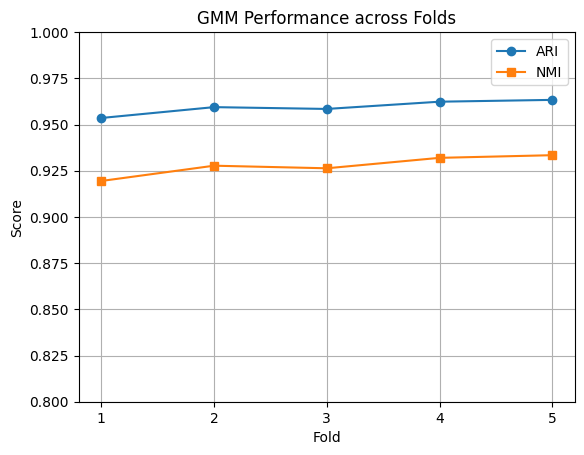

In [9]:
import matplotlib.pyplot as plt

folds = list(range(1, 6))

plt.figure()
plt.plot(folds, ari_scores, marker='o', label="ARI")
plt.plot(folds, nmi_scores, marker='s', label="NMI")
plt.xticks(folds)
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("GMM Performance across Folds")
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.legend()
plt.show()
